In [ ]:
mustang = [1/150.939, 1/76.19, 1/41.6546]
wolf = [50/2219., 50./1299, 50/1000.]
procs = [256, 512, 1024]
procFull = np.linspace(128,1200,20)
mus_ideal = mustang[0]/procs[0]*(procFull)
wolf_ideal = wolf[0]/procs[0]*(procFull)
plt.plot(procs,mustang,color='k',linestyle='none',marker='o',markersize=12)
#plt.plot(procs,wolf,linestyle='none',marker='o',markersize=12,color='b')
plt.plot(procFull,mus_ideal,'--k')
#plt.plot(procFull,wolf_ideal,'--b')
#plt.ylim(0.001,0.03)
plt.xlim(50,1200)
plt.ylabel('Timesteps per second',fontsize=24)
plt.xlabel('Number of processors',fontsize=24)
plt.legend(['Mustang','Ideal Scaling'],loc='upper left', fontsize=24)

In [1]:
from netCDF4 import Dataset,netcdftime,num2date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import time
import datetime
import pandas as pd
#import mldCalc
import readData
import newNCARread
import sys
import fastMLD
import fastBLD

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Rectangle
import xarray as xray
from mpas_xarray import preprocess_mpas, remove_repeated_time_index

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 10) # Large figures
dpi=200;

In [2]:
### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [3]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [4]:
hexcols = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', 
           '#CC6677', '#882255', '#AA4499', '#661100', '#6699CC', '#AA4466',
           '#4477AA']

greysafecols = ['#809BC8', '#FF6666', '#FFCC66', '#64C204']

xarr = [[12], 
        [12, 6], 
        [12, 6, 5], 
        [12, 6, 5, 3], 
        [0, 1, 3, 5, 6], 
        [0, 1, 3, 5, 6, 8], 
        [0, 1, 2, 3, 5, 6, 8], 
        [0, 1, 2, 3, 4, 5, 6, 8], 
        [0, 1, 2, 3, 4, 5, 6, 7, 8], 
        [0, 1, 2, 3, 4, 5, 9, 6, 7, 8], 
        [0, 10, 1, 2, 3, 4, 5, 9, 6, 7, 8], 
        [0, 10, 1, 2, 3, 4, 5, 9, 6, 11, 7, 8]]

# get specified nr of distinct colours in HTML hex format.
# in: nr - number of colours [1..12]
# returns: list of distinct colours in HTML hex
def get_distinct(nr):

    #
    # check if nr is in correct range
    #
    
    if nr < 1 or nr > 12:
        print "wrong nr of distinct colours!"
        return

    #
    # get list of indices
    #
    
    lst = xarr[nr-1]
    
    #
    # generate colour list by stepping through indices and looking them up
    # in the colour table
    #

    i_col = 0
    col = [0] * nr
    for idx in lst:
        col[i_col] = hexcols[idx]
        i_col+=1
    return col

In [5]:
dayval = 9
hourstart = 6
hourend = 12

#These values are for the daily averaged plots (bottom and top of plot)
bigZvalBot = -53
bigZvalTop = -2

#choose number of ticks on x-axis of daily avg plots
nticks = 4

In [6]:
#Set colors for line plots

cvs1 = get_distinct(4)
MOMcolors = [cvs1[1],cvs1[2],cvs1[3],cvs1[1],cvs1[2],cvs1[3]]
MOMlinstyle = ['dashed','dashed','dashed','dashed','dashed','dashed'];
MOMlinethick = ['2','2','2','6','6','6']
MOMmarkstyle = ['None','None','None','None','None','None']
MOMmarksize = ['0','0','0','0','0','0']
MOMplot = np.asarray([MOMcolors,MOMlinstyle,MOMlinethick,MOMmarkstyle,MOMmarksize]).T

MPAScolors = [cvs1[1],cvs1[2],cvs1[3],cvs1[1],cvs1[2],cvs1[3]]
MPASlinstyle = ['solid','solid','solid','solid','solid','solid'];
MPASlinethick = ['2','2','2','6','6','6']
MPASmarkstyle = ['None','None','None','None','None','None']
MPASmarksize = ['0','0','0','0','0','0']
MPASplot = np.asarray([MPAScolors,MPASlinstyle,MPASlinethick,MPASmarkstyle,MPASmarksize]).T

POPcolors = [cvs1[1],cvs1[2],cvs1[3],cvs1[1],cvs1[2],cvs1[3]]
POPlinstyle = ['solid','solid','solid','solid','solid', \
               'solid'];
POPlinethick = ['6','6','6','2','2','2']
POPmarkstyle = ['D','D','D','D','D','D']
POPmarksize = ['9','9','9','9','9','9']
POPplot = np.asarray([POPcolors,POPlinstyle,POPlinethick,POPmarkstyle,POPmarksize]).T

lescolor = cvs1[0]
leslinethick = '4'
leslinstyle = 'solid'

analyticcolor = cvs1[0]
analyticlinethick = '4'
analyticlinestyle = 'dashed'

In [16]:
#choose test case and files to read
testcase = 'AllForcingML'
avInt = '1H' #Averaging Interval H for hour T for minute

POPdir = '/net/scratch3/lvanroekel/POP_data/'
POPtests = {}#{'POP_Base_10m':[POPdir+'Convect5_10m_enhanced.nc',POPcolors[0],POPlinstyle[0],POPlinethick[0]]}#, \
#           'POP_Base_1m':[POPdir+'Convect1_1m.nc',POPcolors[1],POPlinstyle[1],POPlinethick[1]]}
    
MOMdir = '/net/scratch3/lvanroekel/'
MOMtests = {}#{'MOM_Base_1m':[MOMdir+'Diurnal4-df-Aug10/1m/',MOMcolors[0],MOMlinstyle[0],MOMlinethick[0]], \
#            'MOM_BaseShear':[MOMdir+'Diurnal4-JHL-Aug10/1m/',MOMcolors[1],MOMlinstyle[1],MOMlinethick[1]],\
#            'MOM_BaseShearAdd':[MOMdir+'Diurnal4-JHL-Add-Aug10/1m/',MOMcolors[2],MOMlinstyle[2],MOMlinethick[2]]}#, \
#           'MOM_Base_cubic':[MOMdir+'SimpleShapes/Cubic/10m/',MOMcolors[2],MOMlinstyle[2],MOMlinethick[2]]}

MPASdir = '/net/scratch1/lvanroekel/planar/AllForcing/forward/'
MPAStests = {'MPAS_Baseline':[MPASdir+'1mres/Baseline/',MPAScolors[0],MPASlinstyle[0],MPASlinethick[0]], \
#             'MPAS_BaselineS':[MPASdir+'1mres/Baseline_Smooth/',MPAScolors[1],MPASlinstyle[1],MPASlinethick[1]], \
#            'MPAS_match':[MPASdir+'1mres/matchBoth/',MPAScolors[2],MPASlinstyle[2], MPASlinethick[2]], \
             'MPAS_BaselineS':[MPASdir+'10mres/Baseline/',MPAScolors[3],MPASlinstyle[3],MPASlinethick[3]], \
            'MPAS_noEnhance':[MPASdir+'1mres/Baseline_noEnhanced/',MPAScolors[4],MPASlinstyle[4],MPASlinethick[4]]}#, \
#            'MPAS_Baseline10m':[MPASdir+'10mres/Baseline_Smooth/',MOMcolors[0],MOMlinstyle[0],MOMlinethick[0]], \
#            'MPAS_matchB10m':[MPASdir+'10mres/matchBoth/',MOMcolors[1],MOMlinstyle[1],MOMlinethick[1]], \
#            'MPAS_matchBS10m':[MPASdir+'10mres/matchBoth_Smooth/',MOMcolors[2],MOMlinstyle[2],MOMlinethick[2]], \
#            'MPAS_noKPP10m':[MPASdir+'10mres/noKPP/',MOMcolors[3],MOMlinstyle[3],MOMlinethick[3]], \
#             'MPAS_noAddBL10':[MPASdir+'10mres/noAddingInBL/',MOMcolors[4],MOMlinstyle[4],MOMlinethick[4]]}#, \
#             'MPAS_BaselineS':[MPASdir+'1mres/Baseline_Smooth/',MOMcolors[2],MOMlinstyle[2], MOMlinethick[2]]}#, \
##            'MPAS_Av1_BaseS':[MPASdir+'AcmeV1/Baseline_Smooth/',MOMcolors[3],MOMlinstyle[3],MOMlinethick[3]]}

In [8]:
## Load LES profile data

t1=time.time()
sys.path.append('/users/lvanroekel/python_scripts/')

reload(newNCARread)


nz=256
nscl=2
base2='/net/scratch3/lvanroekel/lvanroekel/NCARLES/'
t=newNCARread.turbRead(base2,testcase,'hist',nz,nscl,['txym','uxym','vxym',\
                                        'wtle','uwle','vwle','z','zz','wxym','ups','vps','wps','utle','vtle', \
                                                       'tps','wtDT','wwT','tpcp','spcp','tpress','wTdot','SGSWT', \
                                                      't_rprod','t_wq','t_wp','t_tau','t_tran','t_buoy',\
                                                      't_diss','t_sprod','wtDT','uwsb','vwsb'])
            
txym=t[0][:,1:nz+1,:];
uxym=t[1][:,1:nz+1]
vxym=t[2][:,1:nz+1]
wtle=t[3][:,:,0]
if nscl > 1:
    wsle=t[3][:,:,1]
wwle=t[11][:,:]
uwle=t[4][:,:]
vwle=t[5][:,:]
uule=t[9][:,:]
vvle=t[10][:,:]
utle=t[12][:,:]
vtle=t[13][:,:]
ztopLES=t[6][:,0:nz+1]
zmidLES=t[7][:,1:nz+1]
wxym=t[8][:,1:nz+1]
tps=t[14][:,:]
wtDT=t[15][:,:]
wwT=t[16][:,:]
tpcp=t[17][:,:]
spcp=t[18][:,:]
tpress=t[19][:,:]
wtdot=t[20][:,:]
sgswt=t[21][:,:]
t_rprod=t[22][:,:]
t_wq=t[23][:,:]
t_wp=t[24][:,:]
t_tau=t[25][:,:]
t_tran=t[26][:,:]
t_buoy=t[27][:,:]
t_diss=t[28][:,:]
t_sprod=t[29][:,:]
wtdt=t[30][:,:]
uwsb=t[31][:,:]
vwsb=t[32][:,:]
tarr=t[33]

time2LES=tarr
nt = len(tarr)
time2LES=np.zeros((len(tarr),nz))
for i in range(nz-1):
    time2LES[:,i]=tarr

print time.time() - t1

77.3518650532


In [9]:
#Create LES dataset for plotting and averaging ease.

tarr = time2LES[:,0] / 86400
dtimes = [datetime.datetime(2000,1,1,0,0,0) + datetime.timedelta(x) for x in tarr]
Scl = 0

if nscl == 1:
    dsLES = xray.Dataset({'temp':(['Time','zm'], txym[:,:,0]-273.15), 'U':(['Time','zm'],uxym), \
                         'V':(['Time','zm'],vxym), 'wt':(['Time','zt'], wtle), 'wb':(['Time','zt'], 9.8*2E-4*wtle), \
                         'ww':(['Time','zt'], wwle), 'uw':(['Time','zt'], uwle), 'vw':(['Time','zt'], vwle), \
                         'uu':(['Time','zt'], uule), 'vv':(['Time','zt'], vvle), 'ut':(['Time','zt'], utle), \
                         'vt':(['Time','zt'], vtle), 'ztop':(['Time','zt'], ztopLES), 'zmid':(['Time','zm'], zmidLES), \
                         'W':(['Time','zt'], wxym), 'tps':(['Time','zm'], tps), 'wtDT':(['Time','zt'], wtDT), \
                         'wwT':(['Time','zt'], wwT), 'tpcp':(['Time','zm'], tpcp), 'tpress':(['Time','zm'], tpress), \
                         'wtdot':(['Time','zt'], wtdot), 'wtsgs':(['Time','zt'], sgswt), \
                         't_rprod':(['Time','zm'], t_rprod), 't_wq':(['Time','zt'], t_wq), 't_wp':(['Time','zt'], t_wp), \
                         't_tau':(['Time','zt'], t_tau), 't_tran':(['Time','zt'], t_tran), \
                         't_buoy':(['Time','zt'], t_buoy), 't_diss':(['Time','zt'], t_diss), \
                         't_sprod':(['Time','zt'], t_sprod), 'wtdt':(['Time','zt'], wtdt), \
                         'uwsgs':(['Time','zt'], uwsb), 'vwsgs':(['Time','zt'], vwsb)}, \
                        coords={'Time':dtimes, 'zt': ztopLES[0,:nz], 'zm': zmidLES[0,:]})
    dsLES['b'] = xray.DataArray(9.8*(2E-4*(txym[:,:,0] - 278.15)), \
                                coords=[dsLES.Time, dsLES.zm], dims=['Time', 'zm'])
    
else:
    dsLES = xray.Dataset({'temp':(['Time','zm'], txym[:,:,0]-273.15), 'salt':(['Time','zm'], txym[:,:,1]) \
                          , 'U':(['Time','zm'],uxym), \
                         'V':(['Time','zm'],vxym), 'wt':(['Time','zt'], wtle), 'ws':(['Time','zt'], wsle), \
                         'wb':(['Time','zm'], 9.8*(2E-4*wtle - 8E-4*wsle)), \
                         'ww':(['Time','zt'], wwle), 'uw':(['Time','zt'], uwle), 'vw':(['Time','zt'], vwle), \
                         'uu':(['Time','zt'], uule), 'vv':(['Time','zt'], vvle), 'ut':(['Time','zt'], utle[:,:,Scl]), \
                         'vt':(['Time','zm'], vtle[:,:,Scl]), 'ztop':(['Time','zt'], ztopLES[:,:nz]), \
                          'zmid':(['Time','zm'], zmidLES), \
                         'W':(['Time','zt'], wxym), 'tps':(['Time','zm'], tps[:,:,Scl]),'sps':(['Time','zm'],tps[:,:,1]), \
                          'wtDT':(['Time','zt'], wtDT[:,:,Scl]), \
                         'wwT':(['Time','zt'], wwT[:,:,Scl]),'wwS':(['Time','zt'], wwT[:,:,1]), 'tpcp':(['Time','zm'], tpcp[:,:,0]), \
                          'tpress':(['Time','zm'], tpress[:,:,Scl]),'spress':(['Time','zt'],wtdot[:,:,1]), \
                         'wtdot':(['Time','zt'], wtdot[:,:,Scl]), 'wtsgs':(['Time','zm'], sgswt[:,:,Scl]), \
                         't_rprod':(['Time','zm'], t_rprod), 't_wq':(['Time','zt'], t_wq), 't_wp':(['Time','zt'], t_wp), \
                         't_tau':(['Time','zt'], t_tau), 't_tran':(['Time','zt'], t_tran), \
                         't_buoy':(['Time','zt'], t_buoy), 't_diss':(['Time','zt'], t_diss), \
                         't_sprod':(['Time','zt'], t_sprod), 'wtdt':(['Time','zt'], wtdt[:,:,Scl]), \
                         'uwsgs':(['Time','zt'], uwsb), 'vwsgs':(['Time','zt'], vwsb), 'spcp':(['Time','zt'], spcp[:,:,0])}, \
                        coords={'Time':dtimes, 'zt': ztopLES[0,:nz], 'zm': zmidLES[0,:]})
    saltref = txym[0,:15,1].mean() - 1
    dsLES['b'] = xray.DataArray(9.8*(2E-4*(txym[:,:,0] - 278.15) - 8E-4*(txym[:,:,1] - saltref)), \
                                coords=[dsLES.Time, dsLES.zm], dims=['Time', 'zm'])
dsLESAv = dsLES.resample(avInt, 'Time')

In [ ]:
1.94041E4/86400

In [ ]:
nz = meanV.dims['zm']
wwTtemp = meanV.tpress.values

for i in range(15,nz-2):
    change = abs(wwTtemp[i+1] - wwTtemp[i])/abs(wwTtemp[i])
    if change > 1:
        wwTtemp[i+1] = wwTtemp[i]

In [ ]:
#Examination of NL transport term

nz = dsLESAv.dims['zm']
sval = datetime.datetime(2000,1,6,0,0)
endval = datetime.datetime(2000,1,14,0,0)

meanV = dsLESAv.sel(Time=slice(sval,endval)).mean(dim='Time')

dwwT = meanV.wwT[:nz-1].values - meanV.wwT[1:].values
dz = meanV.zmid[:nz-1].values - meanV.zmid[1:].values
dT = meanV.temp[:nz-1].values - meanV.temp[1:].values
sumthing = -meanV.ww[1:].values*dT[:]/dz[:] - 0.0*dwwT[:]/dz[:] + \
                0.2*2E-4*9.8106*meanV.tps[1:].values

bFlux = 9.8106*(2E-4*1.787E-5 + 8E-4*0*35)
wstar = (-bFlux*meanV.H.values)**(1./3.)  
b = 2
HM_param = meanV.tpress[1:] + b*wstar*1.787E-5/abs(meanV.H.values)
plt.plot(-dwwT[:]/dz[:],-meanV.ztop[1:].values/meanV.H.values,'b')
plt.plot(meanV.tpress[1:].values,-meanV.ztop[1:].values/meanV.H.values,'k')
plt.plot(0.5*2E-4*9.8106*meanV.tps[:].values,-meanV.ztop[:].values/meanV.H.values,'r')
plt.plot(HM_param,-meanV.ztop[1:].values/meanV.H.values,'g')
plt.plot(-meanV.ww[1:].values*dT[:]/dz[:],-meanV.ztop[1:].values/meanV.H.values,'--k')
#plt.plot(-meanV.wt[1:]/sumthing,meanV.ztop[1:].values,'k')

#plot a zero line
yvals = np.linspace(0,1,10)
xvals = np.zeros(10)
plt.plot(xvals,yvals,'--k')
plt.xlim(-2E-7,2E-7)
plt.ylim(-1,-0.01)

In [10]:
MomDictionary = {'temp':'temp','salt':'salt','zl':'zm','zi':'zt','u':'U','v':'V','KPP_OBLdepth':'H','KPP_Kv':'kv', \
                 'KPP_Kheat':'kh','KPP_buoyFlux':'bsfc','KPP_uStar':'ustar2','KPP_NLtransport_heat':'nlt', \
                'KPP_N2':'N2'}
POPDictionary = {'thetao':'temp','so':'salt','zw':'ztop','nlev':'zm','nface':'zt',\
                'blot':'H','uo':'U','vo':'V','difvho':'kh','difvmo':'kv','difvhonl':'nlt'}
MPASDictionary = {'temperature':'temp','salinity':'salt','zMid':'zmid','zTop':'ztop','velocityZonal':'U', \
                  'velocityMeridional':'V','boundaryLayerDepth':'H','vertViscTopOfCell':'kv', \
                 'vertDiffTopOfCell':'kh','surfaceBuoyancyForcing':'bsfc','surfaceFrictionVelocity':'ustar2', \
                 'vertNonLocalFluxTemp':'nlt','nVertLevels':'zm','nVertLevelsP1':'zt', \
                 'BruntVaisalaFreqTop':'N2'}

In [17]:
reload(readData)
for keys, values in MPAStests.iteritems():
    f1 = values[0]+'output/KPP_test.0000-01-01_00.00.00.nc'
    print keys
    exec(keys+', '+keys+'Av = readData.readData("MPAS", f1, MPASDictionary, avInt, testcase)')

MPAS_BaselineS
MPAS_noEnhance
MPAS_Baseline


In [ ]:
reload(readData)
for keys, values in POPtests.iteritems():
    f1 = values[0]
    print keys
    exec(keys+', '+keys+'Av = readData.readData("POP", f1, POPDictionary, avInt, testcase)')

In [ ]:
for keys, values in MOMtests.iteritems():
    f1 = values[0]+'visc.nc'
    f2 = values[0]+'prog.nc'
    print keys
    exec(keys+', '+keys+'Av = readData.readData("MOM", f1, MomDictionary, avInt, testcase, f2)')

In [ ]:
#Compute value of Cstar
wts = 75./4.2E6
b = 2

avgStart = datetime.datetime(2000,1,9,0,0,0)
avgEnd = datetime.datetime(2000,1,10,0,0,0)
dsAv = dsLESAv.sel(Time=slice(avgStart,avgEnd)).mean(dim='Time')

wstar = (-dsAv.H.values*9.8106*2E-4*wts)**(1./3.)
gamma1 = b*wstar**2/(dsAv.ww.values)
gamma2 = 9.8106*2E-4*wstar*abs(dsAv.H.values)*dsAv.tps.values/(wts*dsAv.ww.values)



In [ ]:
fig,ax = plt.subplots()
ax.plot(gamma1,dsAv.zmid.values/dsAv.H.values,'k')
ax.plot(gamma2,dsAv.zmid.values/dsAv.H.values,'--k')
ax.set_ylim(0,1)
ax.set_xlim(0,20)
ax.set_aspect(1./ax.get_data_ratio())

In [ ]:
#Compute theoretical MLD for encroaching and entraining BLs

try:
    exec('dsource = '+MPAStests.keys()[0])
except:
    exec('dsource = '+MOMtests.keys()[0])

if testcase=='ConvectNew':
    tempgrad = 0.01
    saltgrad = 0.0
    sfcheat = 75/4.2E6
    salFlux = 0.0
elif testcase == 'ConvectSalt':
    tempgrad = 0.01
    saltgrad = 0.0
    sfcheat = 75/4.2E6
    salFlux = -1.585E-8*35
elif testcase == 'SaltML':
    tempgrad = 0.0
    saltgrad = -0.007813
    sfcheat = 0.0
    salFlux = -1.585E-8*35
else:
    tempgrad = 0.0
    saltgrad = 0.0
    sfcheat = 0.0
    salFlux = 0.0
    
buoyflux=9.81*2.E-4*sfcheat - 8E-4*9.81*salFlux #buoyancy flux
N2=9.81*(2.E-4*tempgrad-8E-4*saltgrad)

tarray = np.arange(0,10,0.25)
henc=np.zeros((len(tarray),1))
hent=np.zeros((len(tarray),1))
for i in range(len(tarray)):
    henc[i]=np.sqrt(2*buoyflux*tarray[i]*86400/N2)
    hent[i]=1.18*np.sqrt(2*buoyflux*tarray[i]*86400/N2)
    
ts = [datetime.datetime(2000,1,1,0,0,0) + datetime.timedelta(days=x) for x in tarray]

In [14]:
nvals = dsLESAv.dims['Time']

if testcase == 'ConvectNew':
    ustar = 0.0*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = -75./4.2E6*np.ones(len(dsLESAv.Time.values))
    saltsfcflux = 0.0*np.ones(len(dsLESAv.Time.values))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)*np.ones(len(dsLESAv.Time.values))
if testcase == 'ConvectSaltWind':
    ustar = 0.01*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = -75./4.2E6*np.ones(len(dsLESAv.Time.values))
    saltsfcflux = 1.585E-8*35*np.ones(len(dsLESAv.Time.values))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
if testcase == 'ConvectSalt':
    ustar = 0.0*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = 0./4.2E6*np.ones(len(dsLESAv.Time.values))
    saltsfcflux = 1.585E-8*35*np.ones(len(dsLESAv.Time.values))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
if testcase == 'noMLdiurnal':
    ustar = 0.0*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = -75/4.2E6
    saltsfcflux = 1.585E-8*35
    bFlux1 = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
    maxD = -np.pi*(bFlux1 / (9.8*2E-4) * 4.2E6)


    swflux = [maxD * max(np.cos(2.*np.pi*((((x-dsLESAv.Time.values[0]) / np.timedelta64(1, 's'))/86400) - 0.5)), 0) for x in dsLESAv.Time.values];
    tempsfcflux = -75/4.2E6*np.ones(len(swflux)) + np.array(swflux)/4.2E6
    saltsfcflux = 1.585E-8*35*np.ones(len(swflux))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
if testcase == 'AllForcingML':
    ustar = 0.01*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = -75/4.2E6
    saltsfcflux = 1.585E-8*35
    bFlux1 = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
    maxD = -np.pi*(bFlux1 / (9.8*2E-4) * 4.2E6)

    swflux = [maxD * max(np.cos(2.*np.pi*((((x-dsLESAv.Time.values[0]) / np.timedelta64(1, 's'))/86400) - 0.5)), 0) for x in dsLESAv.Time.values];

    tempsfcflux = -75/4.2E6*np.ones(len(swflux)) + np.array(swflux)/4.2E6
    saltsfcflux = 1.585E-8*35*np.ones(len(swflux))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)
if testcase == 'Shear':
    ustar = 0.1*np.ones(len(dsLESAv.Time.values))
    tempsfcflux = 0.0/4.2E6*np.ones(len(dsLESAv.Time.values))
    saltsfcflux = 0.0*np.ones(len(dsLESAv.Time.values))
    buoyflux = 9.8*(2E-4*tempsfcflux - 8E-4*saltsfcflux)*np.ones(len(dsLESAv.Time.values))
bldLES1=np.zeros(nvals)
bldLES2=np.zeros(nvals)
bldLES3=np.zeros(nvals)
bldLES4=np.zeros(nvals)
bldLES5=np.zeros(nvals)
bldKPP=np.zeros(nvals)

refT = 5
refS = dsLESAv.salt[0,0:10].mean()
shiftVal = 0

for i in range(nvals):
    
    minwBspot=dsLESAv.wb[i,:].values.argmin()
    minwB = 0.1*dsLESAv.wb[i,:].values.min()
    j = minwBspot + 1
    while dsLESAv.wb[i,j].values < minwB:
        j += 1
    bldLES1[i] = dsLESAv.ztop[i,minwBspot].values

    bldLES2[i] = dsLESAv.ztop[i,j].values
    
    j = minwBspot - 1
    while dsLESAv.wb[i,j].values < minwB:
        j -= 1
    bldLES3[i] = dsLESAv.ztop[i,j].values
    
#    bldLoc = abs(ztopLES[i,:] - bldLES[i]).argmin() + 1
    tkeTot = 0.5*(dsLESAv.uu[i,:].values + dsLESAv.vv[i,:].values + dsLESAv.ww[i,:].values)
    tkeMax = max(tkeTot)
    
    minTKE = 0.05*tkeMax
    j = 0
#    if bldLoc != 1:
    while tkeTot[j] > minTKE and j < nz-1:
        j += 1
    if j > 200:
        j = 1
        
    bldLES4[i] = dsLESAv.ztop[i,j].values
    
    totFlux = abs((dsLESAv.uw[i,:].values) + (dsLESAv.vw[i,:].values))
#    spot = abs(totFlux - 0.05*ustar**2).argmin()
#    if spot == nz:
#        spot -= 1
#    bldLES5[i] = dsLESAv.ztop[i,spot].values
        
delta = np.zeros((len(tarr),1))

delta = bldLES2 - bldLES3

dsLESAv['H'] = xray.DataArray(bldLES4, coords = [dsLESAv.Time], dims=['Time'])
dsLESAv['bldMinWB'] = xray.DataArray(bldLES1, coords = [dsLESAv.Time], dims=['Time'])
saltref = dsLESAv.salt[0,0].values

dsLES['b'] = xray.DataArray(9.8*(2e-4*(dsLES.temp - 5) - 8E-4*(dsLES.salt - saltref)), coords = [dsLES.Time, dsLES.zm], \
                           dims=['Time','zm'])

dsLESAv['b'] = xray.DataArray(9.8*(2e-4*(dsLESAv.temp - 5) - 8E-4*(dsLESAv.salt - saltref)),  \
                              coords = [dsLESAv.Time, dsLESAv.zm], dims=['Time','zm'])


    
nvals = dsLESAv.dims['Time'];
nz = dsLESAv.dims['zm'];

N2T = (dsLESAv.b[:nvals,:nz-1].values - dsLESAv.b[:nvals,1:].values) / (dsLESAv.zmid[:nvals,:nz-1].values - \
                                                                        dsLESAv.zmid[:nvals,1:].values)
N2T = np.vstack([N2T.T, np.zeros(nvals)]).T

inds = np.where(N2T < 0)
N2T[inds] = 0.0
dsLESAv['N2'] = xray.DataArray(np.sqrt(N2T), \
                            coords=[dsLESAv.Time, dsLESAv.zm], dims=['Time','zm']);

for i in range(nvals-1):
    bldKPP[i]=fastBLD.computeBLD(2,0.25,dsLESAv.zmid[i:i+1,:].values, dsLESAv.ztop[i:i+1,:].values,0.1,True, \
                               dsLESAv.temp[i:i+1,:].values, dsLESAv.salt[i:i+1,:].values,  \
                                     dsLESAv.U[i:i+1,:].values, dsLESAv.V[i:i+1,:].values, \
                               np.roll(dsLESAv.N2[i:i+1,:].values,shiftVal), 0, buoyflux[i], \
                               ustar[i], refT, refS, True)
    
dsLESAv['HKPP'] = xray.DataArray(bldKPP, coords = [dsLESAv.Time], dims=['Time'])  

In [ ]:
dsLES.temp[0,:10].values

In [ ]:
MPAS_BaselineAv.temp[0,:10].values

In [ ]:
print saltref, dsLES.salt[0,0].values, MPAS_Baseline.salt[0,0].values

In [ ]:
dicts = {'POP':POPtests,'MPAS':MPAStests,'MOM':MOMtests}

In [ ]:
levels=np.linspace(19.5,20,16)
fig, ax = plt.subplots()
sval = datetime.datetime(2000,1,9,6,0)
endval = datetime.datetime(2000,1,10,6,0)



for keyvals, valvals in dicts.iteritems():
    for keys, vals in valvals.iteritems():
        exec('dsource = '+keys+'.sel(Time=slice(sval,endval));')

        CS=ax.contour(dsource.Time.values,dsource.zmid[0,:].values, dsource.temp.T.values - 0.25,levels, \
                 linewidths=vals[3],linestyles=vals[2],colors=vals[1],label=keys)
        ax.clabel(CS, inline=1, fontsize=10)

CS=ax.contour(dsLESAv.sel(Time=slice(sval,endval)).Time.values,dsLESAv.sel(Time=slice(sval,endval)).zmid[0,:], \
   dsLESAv.sel(Time=slice(sval,endval)).temp.T.values-0.25,levels, linewidth=leslinethick,linestyle=leslinstyle,colors=lescolor, \
label='LES')
##ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.set_xticklabels([' ','1','2','3','4','5','6','7','8','9'])
ax.set_ylim(-54,0)

In [ ]:
#only for noML diurnal

fig,ax = plt.subplots()
sval = datetime.datetime(2000,1,7,12,0)
endval = datetime.datetime(2000,1,9,12,0)

bmin = abs(MPAS_Baseline.buoyFlux.min().values)
for keyvals, valvals in dicts.iteritems():
    for keys, vals in valvals.iteritems():
        exec('dsource = '+keys+'.sel(Time=slice(sval,endval));')

        ps=ax.contour(dsource.Time.values,dsource.ztop[0,:].values,-dsource.wb.values.T/bmin \
            ,levels=[-0.2,-0.1,0.1,0.3,0.5,0.7,0.9],linewidths=vals[3],linestyles=vals[2],colors=vals[1],label=keys)
        ax.clabel(ps, inline=1, fontsize=10)
    
dsource = dsLESAv.sel(Time=slice(sval,endval))

ps=ax.contour(dsource.Time.values,dsource.ztop[0,:].values,dsource.wb.values.T/bmin \
            ,levels=[-0.2,-0.1,0.1,0.3,0.5,0.7,0.9],linewidths=4,linestyles=leslinstyle,colors=lescolor, \
                label='LES')
ax.clabel(ps, inline=1, fontsize=10)
    
#ax.plot(dsource.Time.values,-dsource.HKPP.values,'k',linewidth=4)
ax.set_xticklabels(['7.5','','8','','8.5','','9','','9.5'])
ax.set_xlabel('Time (days)',fontsize=24)
ax.set_ylabel('Depth (m)',fontsize=24)
ax.set_ylim(-47,-2)

In [ ]:
fig,ax = plt.subplots()
sval = datetime.datetime(2000,1,1,6,0)
endval = datetime.datetime(2000,1,10,6,0)
dsource = dsLESAv.sel(Time=slice(sval,endval))

ps=ax.contourf(dsource.Time.values,dsource.zmid[0,:].values,dsource.b.values.T \
            ,levels=np.linspace(0.029,0.0298,51),cmap='seismic')
fig.colorbar(ps,ticks=[0.029, 0.0291, 0.0292, 0.0293, 0.0294, 0.0295, 0.0296, 0.0297, 0.0298])
ax.plot(dsource.Time.values,-dsource.HKPP.values,'k',linewidth=4)
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Depth (m)')
ax.set_ylim(-47,-2)
#fig.savefig('/usr/projects/climate/lvanroekel/BLD_noml_buoyTime_LES.png')

(-47, -2)

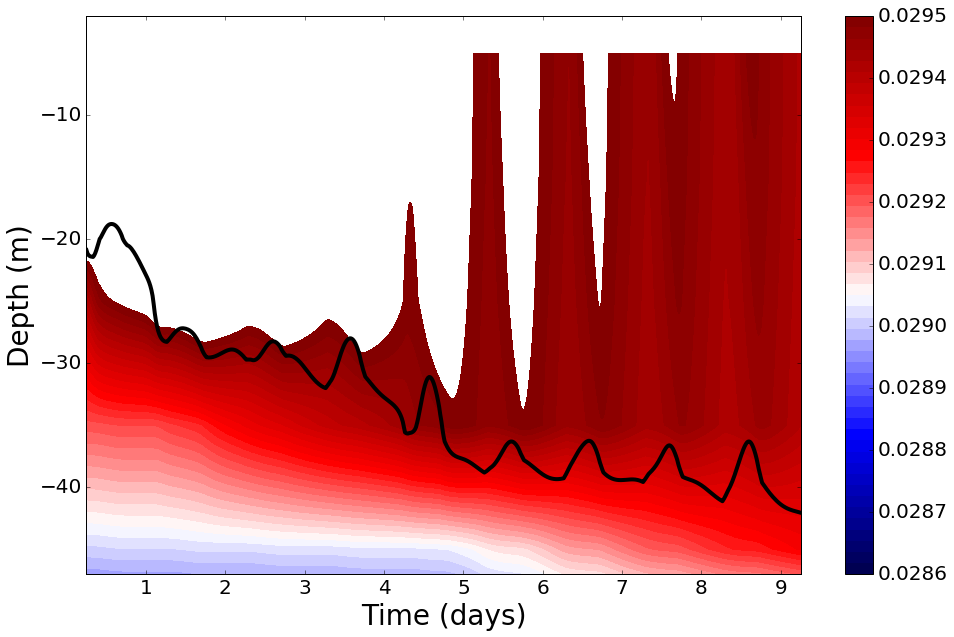

In [18]:
fig,ax = plt.subplots()
sval = datetime.datetime(2000,1,1,6,0)
endval = datetime.datetime(2000,1,10,6,0)
dsource = MPAS_BaselineS.sel(Time=slice(sval,endval))

ps=ax.contourf(dsource.Time.values,dsource.zmid[0,:].values,dsource.b.values.T \
            ,levels=np.linspace(0.0286,0.0295,51),cmap='seismic')
fig.colorbar(ps,ticks=[0.0286, 0.0287, 0.0288, 0.0289, 0.029, 0.0291, 0.0292, 0.0293, 0.0294, 0.0295])
ax.plot(dsource.Time.values,-dsource.H.values,'k',linewidth=4)
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Depth (m)')
ax.set_ylim(-47,-2)

#fig.savefig('/usr/projects/climate/lvanroekel/BLD_nomldiurnal_buoyTime_base.png')

In [ ]:
saltref

In [ ]:
fig,ax = plt.subplots()
sval = datetime.datetime(2000,1,1,6,0)
endval = datetime.datetime(2000,1,10,6,0)
dsource = MPAS_Baseline10m.sel(Time=slice(sval,endval))

ps=ax.contourf(dsource.Time.values,dsource.zmid[0,:].values,dsource.b.values.T \
            ,levels=np.linspace(0.0286,0.0295,51),cmap='seismic')
fig.colorbar(ps,ticks=[0.0286, 0.0287, 0.0288, 0.0289, 0.029, 0.0291, 0.0292, 0.0293, 0.0294, 0.0295])
ax.plot(dsource.Time.values,-dsource.H.values,'k',linewidth=4)
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Depth (m)')
ax.set_ylim(-37,-2)
fig.savefig('/usr/projects/climate/lvanroekel/BLD_noml_buoyTime_base10m.png')

(-47, 0)

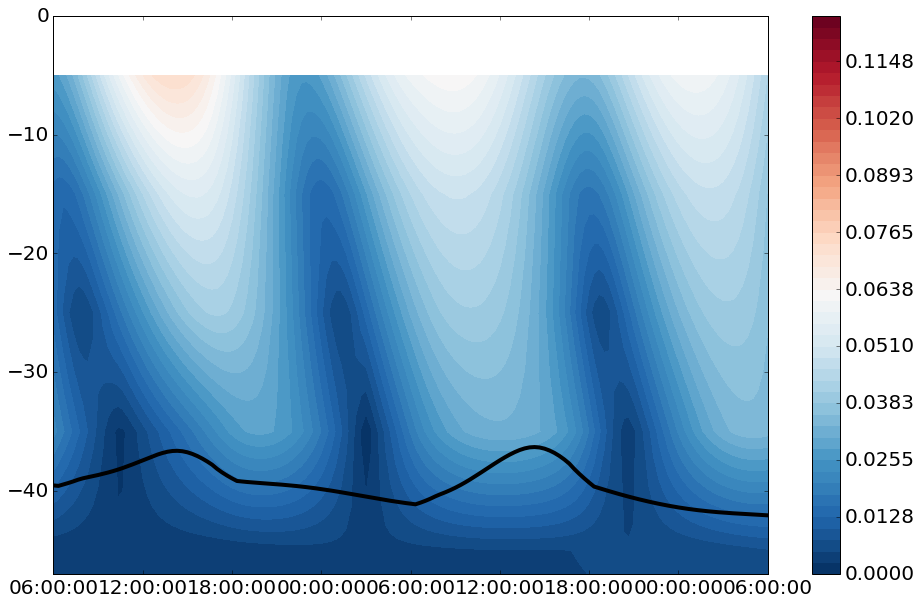

In [19]:
sval = datetime.datetime(2000,1,8,6,0)
endval = datetime.datetime(2000,1,10,6,0)
dsource = MPAS_BaselineS.sel(Time=slice(sval,endval))
cur = np.sqrt(dsource.U.values.T**2 + dsource.V.values.T**2)
plt.contourf(dsource.Time.values,dsource.zmid[0,:].values,cur \
            ,levels=np.linspace(0.0,.125,50),cmap='RdBu_r')
plt.colorbar()
plt.plot(dsource.Time.values,-dsource.H.values,'k',linewidth=4)
plt.ylim(-47,0)

In [ ]:
sval = datetime.datetime(2000,1,1,6,0)
endval = datetime.datetime(2000,1,3,6,0)
dsource = MOM_BaseShear.sel(Time=slice(sval,endval))
cur = np.sqrt(dsource.U.values.T**2 + dsource.V.values.T**2)
plt.contourf(dsource.Time.values,dsource.zmid[0,:].values,cur \
            ,levels=np.linspace(0.0,.125,50),cmap='RdBu_r')
plt.colorbar(ticks=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12])
plt.plot(dsource.Time.values,-dsource.H.values,'k',linewidth=4)
plt.ylim(-47,0)

In [ ]:
sval = datetime.datetime(2000,1,1,6,0)
endval = datetime.datetime(2000,1,3,6,0)
dsource = MOM_BaseShearAdd.sel(Time=slice(sval,endval))
cur = np.sqrt(dsource.U.values.T**2 + dsource.V.values.T**2)
plt.contourf(dsource.Time.values,dsource.zmid[0,:].values,cur \
            ,levels=np.linspace(0.0,.125,50),cmap='RdBu_r')
plt.colorbar()
plt.plot(dsource.Time.values,-dsource.H.values,'k',linewidth=4)
plt.ylim(-47,0)

In [ ]:
dsource.wb[:,0].values.shape

In [ ]:
fig,ax=plt.subplots()

sval = datetime.datetime(2000,1,1,6,0)
endval = datetime.datetime(2000,1,10,6,0)
dsource = MOM_BaseShearAdd.sel(Time=slice(sval,endval))
bmin = abs(dsource.buoyFlux.min().values)

levs=[-5E-4,-3E-4,0,5E-4,1E-3,3E-3,6E-3,9E-3,0.015,0.02,0.03,0.04,0.05]
ps=ax.contourf(dsource.Time.values,dsource.ztop[0,:].values,-dsource.wb.values.T/bmin,levels=np.linspace(-1,1,51), cmap='seismic')
fig.colorbar(ps,ticks=[-.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8])
ax.plot(dsource.Time.values,-dsource.H.values,'k',linewidth=4)
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Depth (m)')
ax.set_ylim(-47,-2)
#fig.savefig('/usr/projects/climate/lvanroekel/BLD_allforcing_buoyFluxTime_MOMAdd.png')

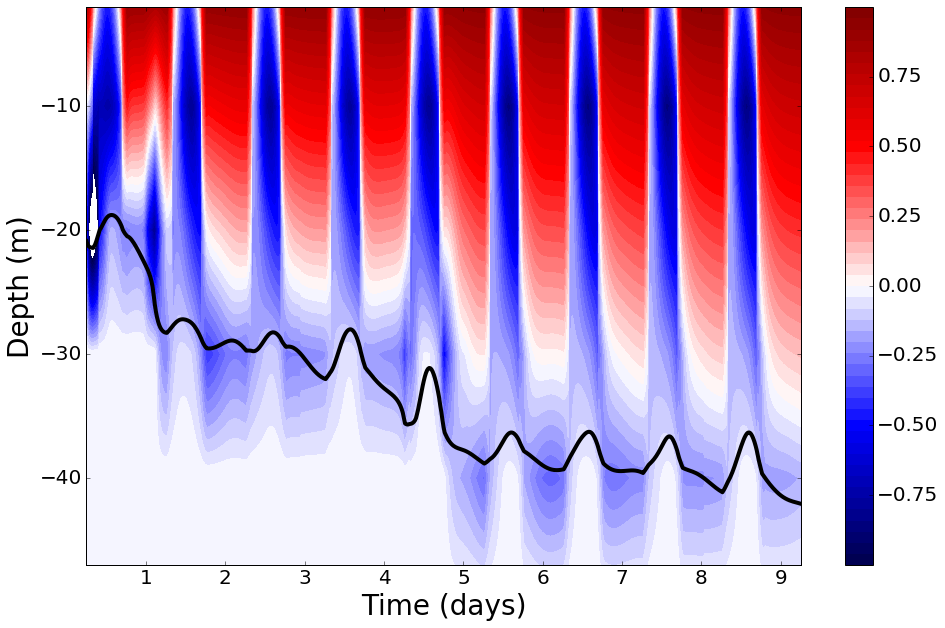

In [22]:
fig,ax=plt.subplots()

sval = datetime.datetime(2000,1,1,6,0)
endval = datetime.datetime(2000,1,10,6,0)
dsource = MPAS_BaselineS.sel(Time=slice(sval,endval))

bmin = abs(MPAS_Baseline.buoyFlux.min().values)

levs=[-5E-4,-3E-4,0,5E-4,1E-3,3E-3,6E-3,9E-3,0.015,0.02,0.03,0.04,0.05]
ps=ax.contourf(dsource.Time.values,dsource.ztop[0,:].values,-dsource.wb.values.T/bmin,levels=np.linspace(-1,1,51), cmap='seismic')
fig.colorbar(ps,ticks=[-.75,-0.5,-0.25,0,0.25,0.5,0.75])
ax.plot(dsource.Time.values,-dsource.H.values,'k',linewidth=4)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Depth (m)')
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
ax.set_ylim(-47,-2)
#fig.savefig('/usr/projects/climate/lvanroekel/BLD_AllForcing_buoyFluxTime_base10m.png')

In [10]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
#####
#fig, ax = plt.subplots(2, 1)

#pcm = ax[0].pcolormesh(X, Y, Z1,
#                       norm=MidpointNormalize(midpoint=0.),
#                       cmap='RdBu_r')
#fig.colorbar(pcm, ax=ax[0], extend='both')

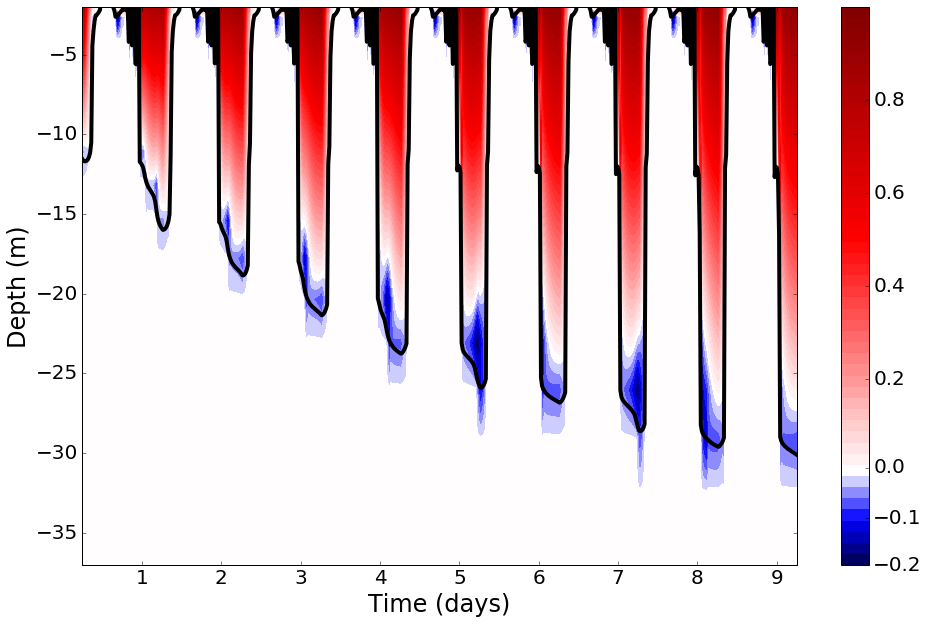

In [13]:
fig,ax=plt.subplots()
sval = datetime.datetime(2000,1,1,6,0)
endval = datetime.datetime(2000,1,10,6,0)
dsource = MPAS_noAddBL.sel(Time=slice(sval,endval))

bmin = abs(MPAS_Baseline.buoyFlux.min().values)
levs=[-5E-4,-3E-4,0,5E-4,1E-3,3E-3,6E-3,9E-3,0.015,0.02,0.03,0.04,0.05]
ps=ax.contourf(dsource.Time.values,dsource.ztop[0,:].values,-dsource.wb.values.T/bmin,levels=np.linspace(-0.2,1,51),\
               norm=MidpointNormalize(midpoint=0), cmap='seismic')
fig.colorbar(ps,ticks=[-.2,-.1,0,0.2,0.4,0.6,0.8])
ax.plot(dsource.Time.values,-dsource.H.values,'k',linewidth=4)
ax.set_xlabel('Time (days)',fontsize=24)
ax.set_ylabel('Depth (m)',fontsize=24)
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
ax.set_ylim(-37,-2)
fig.savefig('/usr/projects/climate/lvanroekel/BLD_noml_buoyFluxTime_AcmeV1.png')

In [ ]:
np.unravel_index(3644,(72,201))

In [ ]:
dsource.kh.values.shape

In [ ]:
i=16
val = MPAS_1m_noKPP.copy()
nzC = val.dims['zm']
dz = (val.zmid[i,:nzC-1].values - val.zmid[i,1:].values)
dudz = (val.U[i,:nzC-1].values - val.U[i,1:].values) / dz
dvdz = (val.V[i,:nzC-1].values - val.V[i,1:].values) / dz
shear = np.sqrt(dudz**2 + dvdz**2)

speed = np.sqrt(val.U[i-1,:].values**2 + val.V[i-1,:].values**2)
Hvals = -val.H[i-1].values*np.ones(10)
xvals = np.linspace(0,1,10)
yval = np.linspace(-50,0,10)
Rvc = 0.7*np.ones(10)
fig,ax1 = plt.subplots()
ax1.plot(val.kh[i,:].values*20,val.ztop[i,:],linewidth=4)
ax1.plot(val.kh[i+1,:].values*20,val.ztop[i,:],'m',linewidth=4)
ax1.plot(val.U[i,:].values,val.zmid[i,:],'g')
ax1.plot(val.V[i,:].values,val.zmid[i,:],'--g')
ax1.plot(xvals,Hvals,'--k',linewidth=4)
ax1.plot(Rvc, yval,color = '0.6', linewidth=4)
ax1.set_xlim(-0.1,1)
ax1.set_ylim(-50,0)
#ax1.set_aspect(1./ax1.get_data_ratio())

ax2 = ax1.twiny()
ax2.plot(val.b[i,:].values,val.zmid[i,:].values,'r',linestyle='none',marker='o',markersize=12)
ax2.plot(val.b[i+1,:].values,val.zmid[i,:].values,'k',linestyle='none',marker='o',markersize=12)
ax2.set_ylim(-20,0)
ax2.set_xlim(0.029075,0.0293)
#ax2.set_aspect(1./ax1.get_data_ratio())

In [ ]:
i=21
val = MPAS_1m_Base.copy()
nzC = val.dims['zm']
dz = (val.zmid[i,:nzC-1].values - val.zmid[i,1:].values)
dV = np.sqrt((val.U[i,:nzC-1].values - val.U[i,1:].values)**2 + \
            (val.V[i,:nzC-1].values - val.V[i,1:].values)**2)
dudz = (val.U[i,:nzC-1].values - val.U[i,1:].values) / dz
dvdz = (val.V[i,:nzC-1].values - val.V[i,1:].values) / dz
shear = dudz**2 + dvdz**2
plt.plot(val.N2[i,:].values,val.ztop[i,:nzC],linestyle='none',marker='s')
#plt.plot((val.N2[i,:].values/val.RiTopOfCell[i,:nzC].values),val.ztop[i,:nzC])
plt.plot(shear,val.ztop[i,1:nzC],linestyle='none',marker='o',markersize=12)

plt.ylim(-45,0)
plt.xlim(-1E-5,10E-4)

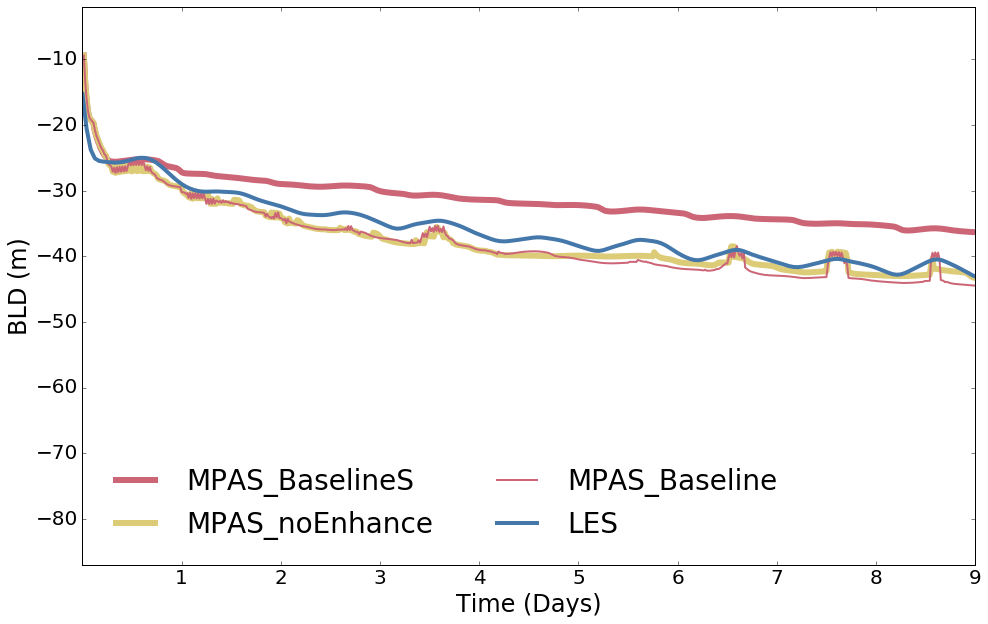

In [15]:
dicts = {'POP':POPtests,'MPAS':MPAStests,'MOM':MOMtests}
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 28})
spot = 20
sval = datetime.datetime(2000,1,1,0,0)
endval = datetime.datetime(2000,1,10,0,0)
for keykeys, valvals in dicts.iteritems():
    for keys, vals in valvals.iteritems():
        exec('dsource = '+keys+';')
    #    if keys[:3] == 'MOM'
        ax.plot(dsource.Time, -dsource.H[:],linewidth=vals[3],linestyle=vals[2],color=vals[1], \
                label=keys);
    
#for keys, vals in MPAStests.iteritems():
#    exec('dsource = '+keys+';')
#    ax.plot(dsource.Time, -dsource.H[:],linewidth=vals[3],linestyle=vals[2],color=vals[1],label=keys);


H = -np.copy(dsLESAv.HKPP.values)

for j in range(4):
    for i in range(1,len(H)-1):
        H[i] = (H[i-1] + H[i] + H[i+1])/3.

ax.plot(dsLESAv.Time,H,linewidth=leslinethick,linestyle=leslinstyle,color=lescolor, \
       label='LES')

#ax.plot(ts,-hent,linewidth=analyticlinethick,linestyle=analyticlinestyle,color='k', \
#       label='Analytic')

ax.set_ylim(-87,-2)
ax.set_xlim(sval, endval)
ax.legend(loc='lower left',frameon=False,fontsize=28,ncol=2)
ax.yaxis.set_major_locator(MultipleLocator(10))
##ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([' ','1','2','3','4','5','6','7','8','9'])
#ax.set_xticklabels(['6',' ','7',' ','8',' ','9'])
ax.set_xlabel('Time (Days)',fontsize=24)
ax.set_ylabel('BLD (m)',fontsize=24)

#fig.savefig('/usr/projects/climate/lvanroekel/BLD_saltforcing_LES.png')

In [ ]:
dayval=1

In [ ]:
endtemp = pd.to_datetime(dsLESAv.Time[-1].values).day-1

for keys, vals in MOMtests.iteritems():
    exec('dsource = '+keys+'Av;')
    endtemp = min(endtemp, pd.to_datetime(dsource.Time[-1].values).day-1)

for keys, vals in MPAStests.iteritems():
    exec('dsource = '+keys+'Av;')
    endtemp = min(endtemp, pd.to_datetime(dsource.Time[-1].values).day-1)

dayval = min(dayval, endtemp)

#Instead loop over all things in keys/dicts so don't have a MOM MPAS stuff

avgStart = datetime.datetime(2000,1,dayval,15,0,0)
avgEnd = datetime.datetime(2000,1,dayval,16,0,0)

In [ ]:
#plot mean buoyancy, u, and v profiles
dicts = {'POP':POPtests,'MPAS':MPAStests,'MOM':MOMtests}

f, axarr = plt.subplots(nrows=1,ncols=1)
v1 = 100000
v2 = 0

for keyvals, valvals in dicts.iteritems():
    for keys, vals in valvals.iteritems():
        exec('dsource = '+keys+'Av.sel(Time=slice(avgStart, avgEnd));')
        axarr.plot(dsource.b.mean(axis=0).values, dsource.zmid[0,:], \
                  linewidth=vals[3],linestyle=vals[2],color=vals[1]);
        axarr.set_ylim([bigZvalBot,bigZvalTop])
    if keys != 'MPAS_1m_Match':
            ymin = axarr.get_ylim()[0]
            ymax = axarr.get_ylim()[1]
            idx1 = find_nearest(dsource.sel(Time=avgStart, method='nearest').zmid.values,ymin)
            idx2 = find_nearest(dsource.sel(Time=avgStart, method='nearest').zmid.values,ymax)
            v1T = dsource.b[:,idx2:idx1].mean(axis=0).values.min()
            v2T = dsource.b[:,idx2:idx1].mean(axis=0).values.max()
            v1 = min(v1T, v1)
            v2 = max(v2T, v2)

axarr.plot(dsLESAv.sel(Time=slice(avgStart, avgEnd)).b.mean(axis=0).values,dsLESAv.zmid[0,:].values, \
           linewidth=leslinethick,linestyle=leslinstyle,color=lescolor)
axarr.set_ylim([bigZvalBot,bigZvalTop])

ymin = axarr.get_ylim()[0]
ymax = axarr.get_ylim()[1]
idx1 = find_nearest(dsLESAv.sel(Time=avgStart, method='nearest').zmid.values,ymin)
idx2 = find_nearest(dsLESAv.sel(Time=avgStart, method='nearest').zmid.values,ymax)
v1T = dsLESAv.sel(Time=slice(avgStart, avgEnd)).b[:,idx2:idx1].mean(axis=0).values.min()
v2T = dsLESAv.sel(Time=slice(avgStart, avgEnd)).b[:,idx2:idx1].mean(axis=0).values.max()
v1 = min(v1T,v1)
v2 = max(v2T,v2)
 
xmin = min(v1,v2)
xmin = np.float64(xmin)
#xmin = xmin - abs(xmin)*0.005

xmax = max(v1,v2)
#xmax = xmax + xmax*0.005

axarr.set_xlim(xmin,xmax)
deltaVal = (xmax - xmin) / 3 
val = deltaVal.round(0)
iii=1
while val==0:
    val = deltaVal.round(iii)
    iii+=1
deltaVal = deltaVal.round(iii-1)
xmin = xmin.round(iii-1)
xmax = xmax.round(iii-1)
axarr.xaxis.set_major_locator(MultipleLocator(deltaVal))
axarr.yaxis.set_major_locator(MultipleLocator(5))

#axarr[0].legend(labs,loc=0,frameon=False)
axarr.set_ylabel('Depth (m)',fontsize=24)
axarr.set_xlabel(r"Buoyancy (m s$^{-2}$)",fontsize=24)
axarr.set_aspect(1./axarr.get_data_ratio())

#f.savefig('/usr/projects/climate/lvanroekel/Allforcing_sunup_buoyProfile.png')

In [ ]:
nticks = 4

f, axarr = plt.subplots(1,2, sharey=False)
umin = 100000
umax = 0
vmin = 100000
vmax = 0

for keyvals, valvals in dicts.iteritems():
    for keys, vals in valvals.iteritems():
        exec('dsource = '+keys+'Av.sel(Time=slice(avgStart, avgEnd));')
        axarr[1].plot(-dsource.U.mean(axis=0).values, dsource.zmid[0,:], \
                  linewidth=vals[3], linestyle=vals[2], color=vals[1])

        axarr[0].plot(-dsource.V.mean(axis=0).values, dsource.zmid[0,:], \
                  linewidth=vals[3], linestyle=vals[2], color=vals[1])

        axarr[0].set_ylim([bigZvalBot,bigZvalTop])
        ymin = axarr[0].get_ylim()[0]
        ymax = axarr[0].get_ylim()[1]
        idx1 = find_nearest(dsource.sel(Time=avgStart, method='nearest').zmid.values,ymin)
        idx2 = find_nearest(dsource.sel(Time=avgStart, method='nearest').zmid.values,ymax)
        uminT = ((dsource.U[:,idx2:idx1].mean(axis=0).values)).min()
        umaxT = ((dsource.U[:,idx2:idx1].mean(axis=0).values)).max()
        vminT = ((dsource.V[:,idx2:idx1].mean(axis=0).values)).min()
        vmaxT = ((dsource.V[:,idx2:idx1].mean(axis=0).values)).max()

        umin = min(uminT, umin)
        umax = max(umaxT, umax)

        vmin = min(vminT, vmin)
        vmax = max(vmaxT, vmax)
    
axarr[1].plot(-dsLESAv.sel(Time=slice(avgStart, avgEnd)).V.mean(axis=0).values, \
             dsLESAv.sel(Time=avgStart, method='nearest').zmid.values, linewidth=leslinethick, \
             linestyle=leslinstyle, color=lescolor)
axarr[0].plot(dsLESAv.sel(Time=slice(avgStart, avgEnd)).U.mean(axis=0).values, \
             dsLESAv.sel(Time=avgStart, method='nearest').zmid.values, linewidth=leslinethick, \
             linestyle=leslinstyle, color=lescolor)

axarr[0].set_ylim([bigZvalBot,bigZvalTop])
axarr[1].set_ylim([bigZvalBot,bigZvalTop])

ymin = axarr[0].get_ylim()[0]
ymax = axarr[1].get_ylim()[1]
idx1 = find_nearest(dsLESAv.sel(Time=avgStart, method='nearest').zmid.values,ymin)
idx2 = find_nearest(dsLESAv.sel(Time=avgStart, method='nearest').zmid.values,ymax)
uminT = ((-dsLESAv.sel(Time=slice(avgStart, avgEnd)).V[:,idx2:idx1].mean(axis=0).values)).min()
umaxT = ((-dsLESAv.sel(Time=slice(avgStart, avgEnd)).V[:,idx2:idx1].mean(axis=0).values)).max()
vminT = ((dsLESAv.sel(Time=slice(avgStart, avgEnd)).U[:,idx2:idx1].mean(axis=0).values)).min()
vmaxT = ((dsLESAv.sel(Time=slice(avgStart, avgEnd)).U[:,idx2:idx1].mean(axis=0).values)).max()

umin = min(uminT, umin)
vmin = min(umin, vmin, vminT)

umax = max(umaxT, umax)
vmax = max(umax, vmax, vmaxT)

xmin = vmin
xmax = vmax

for kkk in range(2):
    axarr[kkk].set_xlim(xmin,xmax)
    deltaVal = (xmax-xmin) / 3 
    val = deltaVal.round(0)
    iii=1
    while val==0:
        val = deltaVal.round(iii)
        iii+=1
    deltaVal = deltaVal.round(iii)

    xmin = xmin.round(iii)
    xmax = xmax.round(iii)

    axarr[kkk].xaxis.set_major_locator(MultipleLocator(deltaVal))
    axarr[kkk].set_aspect(1./axarr[kkk].get_data_ratio())

    axarr[kkk].yaxis.set_major_locator(MultipleLocator(10))
    axarr[kkk].yaxis.set_major_locator(MultipleLocator(10))

axarr[0].set_ylabel('Depth (m)',fontsize=24)
    
#axarr[1,0].set_xlim([-.3,.3])
#axarr[0,0].set_xlabel(r"$\frac{\overline{u^\prime w^\prime}}{u_*^2}$, $\frac{\overline{v^\prime w^\prime}}{u_*^2}$  ",fontsize=24)
axarr[0].set_xlabel(r"u-velocity (ms$^{-1}$)",fontsize=24)
axarr[1].set_xlabel(r"v-velocity (ms$^{-1}$)",fontsize=24)

#axarr[0,0].legend(labs,loc=0)
#labs=['Udeep','Vdeep','U250','V250','Uhigh','Vhigh','Unew','Vnew','ULES','VLES']
#axarr[1].legend(labs,loc=3)
f.tight_layout()
axarr[0].set_aspect(1./axarr[0].get_data_ratio())
axarr[1].set_aspect(1./axarr[1].get_data_ratio())

#f.subplots_adjust(right=0.675)
#f.savefig('/usr/projects/climate/lvanroekel/Allforcing_sunup_currentsAv1.png')

In [ ]:
dsource.buoyFlux.values

In [ ]:
f, axarr = plt.subplots(1,1, sharey=False)
v1 = 100000
v2 = 0

for keyvals, valvals in dicts.iteritems():
    for keys, vals in valvals.iteritems():
        exec('dsource = '+keys+'Av.sel(Time=slice(avgStart, avgEnd));')
        buoyflux = abs(dsource.buoyFlux.mean().values)
        buoyflux = 1.0
        axarr.plot(-dsource.wb.mean(axis=0).values/buoyflux, dsource.sel(Time=avgStart, method='nearest').ztop.values, \
                  linewidth=vals[3],linestyle=vals[2],color=vals[1]);
        axarr.set_ylim([bigZvalBot, bigZvalTop])
        ymin = axarr.get_ylim()[0]
        ymax = axarr.get_ylim()[1]
        print buoyflux
        if keys != 'MPAS_1m_Match':
            idx1 = find_nearest(dsource.sel(Time=avgStart, method='nearest').ztop.values,ymin)
            idx2 = find_nearest(dsource.sel(Time=avgStart, method='nearest').ztop.values,ymax)
            v1T = (-(dsource.wb[:,idx2:idx1].mean(axis=0).values)/buoyflux).min()
            v2T = (-(dsource.wb[:,idx2:idx1].mean(axis=0).values)/buoyflux).max()
            v1 = min(v1T, v1)
            v2 = max(v2T, v2)
    
axarr.plot(dsLESAv.sel(Time=slice(avgStart,avgEnd)).wb.mean(axis=0).values/buoyflux,dsLESAv.ztop[0,:].values, \
           linewidth=leslinethick,linestyle=leslinstyle,color=lescolor)
axarr.set_ylim([bigZvalBot,bigZvalTop])
#axarr.set_ylim([-20,0])
ymin = axarr.get_ylim()[0]
ymax = axarr.get_ylim()[1]
idx1 = find_nearest(dsLESAv.sel(Time=avgStart, method='nearest').zmid.values,ymin)
idx2 = find_nearest(dsLESAv.sel(Time=avgStart, method='nearest').zmid.values,ymax)
v1T = ((dsLESAv.sel(Time=slice(avgStart, avgEnd)).wb[:,idx2:idx1].mean(axis=0).values)/buoyflux).min()
v2T = ((dsLESAv.sel(Time=slice(avgStart, avgEnd)).wb[:,idx2:idx1].mean(axis=0).values)/buoyflux).max()
v1 = min(v1T,v1)
v2 = max(v2T,v2)

xmin = min(v1,v2)
xmax = max(v1,v2)


deltaVal = (xmax - xmin) / 3 
val = deltaVal.round(0)
iii=1
while val==0:
    val = deltaVal.round(iii)
    iii+=1
deltaVal = deltaVal.round(iii)
xmin = xmin.round(iii)
axarr.set_xlim(xmin,xmax)
xmax = xmax.round(iii)
axarr.xaxis.set_major_locator(MultipleLocator(deltaVal))   

axarr.yaxis.set_major_locator(MultipleLocator(5))
axarr.set_aspect(1./axarr.get_data_ratio())

#labs=names+['LES']
#axarr[0].legend(labs,loc=0)
axarr.set_ylabel('Depth (m)',fontsize=24)
axarr.set_xlabel(r"$\frac{\overline{w^\prime b^\prime}}{\overline{w^\prime b^\prime}_o}$",fontsize=24)


#f.savefig('/usr/projects/climate/lvanroekel/Allforcing_sunup_buoyfluxAv1.png')

In [ ]:
dsource.zmid[0,:].values.shape

In [ ]:
ustar**2

In [ ]:
f, axarr = plt.subplots(1,2, sharey=False)
umin = 100000
umax = 0
vmin = 100000
vmax = 0

for keyvals, valvals in dicts.iteritems():
    for keys, vals in valvals.iteritems():
        exec('dsource = '+keys+'Av.sel(Time=slice(avgStart, avgEnd));')
        ustar = dsource.ustar.mean().values
        
        axarr[0].plot(dsource.uw.mean(axis=0).values/(ustar**2 + 1E-15), dsource.ztop[0,:], \
                  linewidth=vals[3], linestyle=vals[2], color=vals[1])

        axarr[1].plot(dsource.vw.mean(axis=0).values/(ustar**2 + 1E-15), dsource.ztop[0,:], \
                  linewidth=vals[3], linestyle=vals[2], color=vals[1])

        axarr[0].set_ylim([bigZvalBot,bigZvalTop])
        ymin = axarr[0].get_ylim()[0]
        ymax = axarr[0].get_ylim()[1]
        idx1 = find_nearest(dsource.sel(Time=avgStart, method='nearest').zmid.values,ymin)
        idx2 = find_nearest(dsource.sel(Time=avgStart, method='nearest').zmid.values,ymax)
        uminT = ((dsource.uw[:,idx2:idx1].mean(axis=0).values)/(ustar**2+1E-15)).min()
        umaxT = ((dsource.uw[:,idx2:idx1].mean(axis=0).values)/(ustar**2+1E-15)).max()
        vminT = ((dsource.vw[:,idx2:idx1].mean(axis=0).values)/(ustar**2+1E-15)).min()
        vmaxT = ((dsource.vw[:,idx2:idx1].mean(axis=0).values)/(ustar**2+1E-15)).max()

        umin = min(uminT, umin)
        umax = max(umaxT, umax)

        vmin = min(vminT, vmin)
        vmax = max(vmaxT, vmax)
    
axarr[0].plot(-dsLESAv.sel(Time=slice(avgStart, avgEnd)).vw.mean(axis=0).values/(ustar**2+1E-15), \
             dsLESAv.sel(Time=avgStart, method='nearest').ztop.values, linewidth=leslinethick, \
             linestyle=leslinstyle, color=lescolor)
axarr[1].plot(dsLESAv.sel(Time=slice(avgStart, avgEnd)).uw.mean(axis=0).values/(ustar**2+1E-15), \
             dsLESAv.sel(Time=avgStart, method='nearest').ztop.values, linewidth=leslinethick, \
             linestyle=leslinstyle, color=lescolor)

axarr[0].set_ylim([bigZvalBot,bigZvalTop])
axarr[1].set_ylim([bigZvalBot,bigZvalTop])

ymin = axarr[0].get_ylim()[0]
ymax = axarr[1].get_ylim()[1]
idx1 = find_nearest(dsLESAv.sel(Time=avgStart, method='nearest').zmid.values,ymin)
idx2 = find_nearest(dsLESAv.sel(Time=avgStart, method='nearest').zmid.values,ymax)
uminT = ((-dsLESAv.sel(Time=slice(avgStart, avgEnd)).vw[:,idx2:idx1].mean(axis=0).values)/(ustar**2 + 1E-15)).min()
umaxT = ((-dsLESAv.sel(Time=slice(avgStart, avgEnd)).vw[:,idx2:idx1].mean(axis=0).values)/(ustar**2 + 1E-15)).max()
vminT = ((dsLESAv.sel(Time=slice(avgStart, avgEnd)).uw[:,idx2:idx1].mean(axis=0).values)/(ustar**2 + 1E-15)).min()
vmaxT = ((dsLESAv.sel(Time=slice(avgStart, avgEnd)).uw[:,idx2:idx1].mean(axis=0).values)/(ustar**2 + 1E-15)).max()

umin = min(uminT, umin)
vmin = min(vmin, vminT)

umax = max(umaxT, umax)
vmax = max(vmax, vmaxT)

xmin = np.zeros(2)
xmax = np.zeros(2)
xmin[0] = umin
xmax[0] = umax
xmin[1] = vmin
xmax[1] = vmax


for kkk in range(2):
    axarr[kkk].set_xlim(xmin[kkk],xmax[kkk])
    deltaVal = (xmax[kkk]-xmin[kkk]) / 3 
    val = deltaVal.round(0)
    iii=1
    while val==0:
        val = deltaVal.round(iii)
        iii+=1
    deltaVal = deltaVal.round(iii)

    xmin = xmin.round(iii)
    xmax = xmax.round(iii)

    axarr[kkk].xaxis.set_major_locator(MultipleLocator(deltaVal))
    axarr[kkk].set_aspect(1./axarr[kkk].get_data_ratio())

    axarr[kkk].yaxis.set_major_locator(MultipleLocator(10))
    axarr[kkk].yaxis.set_major_locator(MultipleLocator(10))


    
axarr[0].set_ylabel('Depth (m)',fontsize=24)
    
#axarr[1,0].set_xlim([-.3,.3])
#axarr[0,0].set_xlabel(r"$\frac{\overline{u^\prime w^\prime}}{u_*^2}$, $\frac{\overline{v^\prime w^\prime}}{u_*^2}$  ",fontsize=24)
axarr[0].set_xlabel(r"$\frac{\overline{u^\prime w^\prime}}{u_*^2}$",fontsize=24)
axarr[1].set_xlabel(r"$\frac{\overline{v^\prime w^\prime}}{u_*^2}$",fontsize=24)

#axarr[0,0].legend(labs,loc=0)
#labs=['Udeep','Vdeep','U250','V250','Uhigh','Vhigh','Unew','Vnew','ULES','VLES']
#axarr[1].legend(labs,loc=3)
f.tight_layout()
axarr[0].set_aspect(1./axarr[0].get_data_ratio())
axarr[1].set_aspect(1./axarr[1].get_data_ratio())

#f.subplots_adjust(right=0.675)
#f.savefig('/usr/projects/climate/lvanroekel/AllForcing_sunup_momentum_fluxAv1.png')


In [ ]:
N2T = dsAv.N2.values.flatten()
ind = np.where(N2T < 0)
N2T[ind] = 0.0
N23 = np.reshape(N2T,(41,20))
dsAv.N2[:,:].values = N23

In [ ]:
N23.shape

In [ ]:
plt.plot(N23[20,:])
plt.plot(dsAv.N2[20,:].values)

In [ ]:
dsAv.N2[row,col].values.max()

In [ ]:
jj=40
import pyximport
pyximport.install(reload_support=True)
import fastBLD
reload(fastBLD)

dsAv = MPAS_PNL_cubic.resample('6H','Time')

nvals = dsAv.dims['Time'];
nz = dsAv.dims['zm'];
        
N2T = dsAv.N2.values.flatten()
inds = np.where(N2T < 0)
N2T[inds] = 0.0
dsAv['N2'] = xray.DataArray(np.sqrt(np.reshape(N2T,(nvals, nz))), \
                                    coords=[dsAv.Time, dsAv.zm], dims=['Time','zm']);
        
bldbase=fastBLD.computeBLD(2,Ri_crit,dsAv.zmid[jj:jj+1,:].values, dsAv.ztop[jj:jj+1,:].values,sigVal,True, \
                                       dsAv.temp[jj:jj+1,:].values, dsAv.salt[jj:jj+1,:].values,  \
                                             dsAv.U[jj:jj+1,:].values, dsAv.V[jj:jj+1,:].values, \
                                       dsAv.N2[jj:jj+1,:].values, 0, -dsAv.buoyflux[jj].values, \
                                       dsAv.ustar[jj].values, refT, refS, True)
print bldbase

In [ ]:
dsLES6h.b.values.shape

In [ ]:
N2T = np.append?

In [ ]:
bb = np.vstack([N2T.T, np.zeros(44)]).T

In [ ]:
[ 51.78642781] -54.5590635935
[ 52.85485696] -55.0154266357
[ 53.9645844] -55.8408292135
[ 55.03571022] -57.7072995504
[ 56.12146419] -58.7497762044
[ 57.16493398] -59.9978701274

In [ ]:
import pyximport
pyximport.install(reload_support=True)
import fastBLD
reload(fastBLD)

Ri_crit = 0.25
sigVal = 0.1
shiftVal = 1

j=0
refT = 5
refS = dsLESAv.salt[0,0:10].mean()

sigVs = np.linspace(0.001,0.25,20)
RiVs = np.linspace(0.2,1,20)

dsLES6h = dsLESAv.resample('6H','Time');
#for keyvals, valvals in dicts.iteritems():
#    for keys, vals in valvals.iteritems():
#        exec('dsAv = '+keys+'.resample("6H","Time")')
    
nvals = dsLES6h.dims['Time'];
nz = dsLES6h.dims['zm'];

N2T = (dsLES6h.b[:,:nz-1].values - dsLES6h.b[:,1:].values) / (dsLES6h.zmid[:,:nz-1].values - dsLES6h.zmid[:,1:].values)
N2T = np.vstack([N2T.T, np.zeros(44)]).T

inds = np.where(N2T < 0)
N2T[inds] = 0.0
dsLES6h['N2'] = xray.DataArray(np.sqrt(N2T), \
                            coords=[dsLES6h.Time, dsLES6h.zm], dims=['Time','zm']);

bldVals = np.zeros((nvals,len(sigVs),len(RiVs)))
errorVals = np.zeros((len(sigVs),len(RiVs)))
refS = dsLES6h.salt[0,0:5].mean()

bFlux = 9.81*(2E-4*(-75./4.2E6) - 8E-4*0.0*35)
ustar = 0.0

for jj in range(nvals/2,nvals-1):
    bldbase=fastBLD.computeBLD(2,Ri_crit,dsLES6h.zmid[jj:jj+1,:].values, dsLES6h.ztop[jj:jj+1,:].values,sigVal,True, \
                               dsLES6h.temp[jj:jj+1,:].values, dsLES6h.salt[jj:jj+1,:].values,  \
                                     dsLES6h.U[jj:jj+1,:].values, dsLES6h.V[jj:jj+1,:].values, \
                               np.roll(dsLES6h.N2[jj:jj+1,:].values,shiftVal), 0, bFlux, \
                               ustar, refT, refS, True)
    
    print bldbase, dsLES6h.H[jj].values
    for i in range(len(sigVs)):
        for j in range(len(RiVs)):
            bld=fastBLD.computeBLD(2,RiVs[j],dsLES6h.zmid[jj:jj+1,:].values, dsLES6h.ztop[jj:jj+1,:].values,sigVs[i], \
                                   True, \
                                   dsLES6h.temp[jj:jj+1,:].values, dsLES6h.salt[jj:jj+1,:].values, \
                                         dsLES6h.U[jj:jj+1,:].values, dsLES6h.V[jj:jj+1,:].values, \
                                   np.roll(dsLES6h.N2[jj:jj+1,:].values,shiftVal), 0, bFlux,ustar, \
                                   refT, refS, True)

            errorVals[i,j] = max(errorVals[i,j], abs((bld[0] + dsLES6h.H[jj].values)/abs(dsLES6h.H[jj].values)))


In [ ]:
len(Time)

In [ ]:
#Computing Crude KPP based on LES output

Time=dsLES6h.Time.values
Rib=np.zeros([nz,len(Time)])
RibUP=np.zeros([nz,len(Time)])
RibDN=np.zeros([nz,len(Time)])
wTloc=np.zeros([nz,len(Time)])
wTnloc=np.zeros([nz,len(Time)])
KPPH=np.zeros(len(Time))
KPPHo=np.zeros(len(Time))
ZIH=0
RichCrit=0.25

for ti,TI in enumerate(Time):
    
    #1. Get Rib
    for zi,ZZ in enumerate(dsLES6h.zmid[ti,:].values):
        #Surf Parameters (need averaged)
        tsurf=dsLES6h.temp[ti,0]
        ssurf=dsLES6h.salt[ti,0]
        rhosurf=1000.-(tsurf-273.15)*2e-4*1000.+ssurf*7.5e-4*1000.
        usurf=dsLES6h.U[ti,0].values
        vsurf=dsLES6h.V[ti,0].values
        ZAVG=np.int(np.floor(ZIH*0.1)+1)
        if ZIH>0:
            tsurf=np.mean(dsLES6h.temp[ti,0:ZAVG].values)
            ssurf=np.mean(dsLES6h.salt[ti,0:ZAVG].values)
            rhosurf=1000.-(tsurf-273.15)*2e-4*1000.+ssurf*7.5e-4*1000.
            usurf=np.mean(dsLES6h.U[ti,0:ZAVG].values)
            vsurf=np.mean(dsLES6h.V[ti,0:ZAVG].values)
        #Depth Parameters
        tdepth=dsLES6h.temp[ti,zi].values
        sdepth=dsLES6h.salt[ti,zi].values
        rhodepth=1000.-(tdepth-273.15)*2e-4*1000.+sdepth*7.5e-4*1000.
        udepth=dsLES6h.U[ti,zi].values
        vdepth=dsLES6h.V[ti,zi].values
        Zup=max(ZIH+1-1,0)
        Zdn=min(ZIH+1+1,nz-1)
        rhoUP=1000.-(dsLES6h.temp[ti,Zup].values-5)*2e-4*1000.+dsLES6h.salt[ti,Zup].values*7.5e-4*1000.
        rhoDN=1000.-(dsLES6h.temp[ti,Zdn].values-5)*2e-4*1000.+dsLES6h.salt[ti,Zdn].values*7.5e-4*1000.
        N=np.sqrt(max(0,(-(rhoUP-rhoDN)/(dsLES6h.zmid[ti,Zup].values-dsLES6h.zmid[ti,Zdn].values)*9.81/1025)))
        wTsurf=1.7875e-5
        BFSFC=wTsurf*10*0.0002
        WS=0.4*(0.4*98.96*0.1*abs(ZZ)*BFSFC)**(1./3)
        Vt2= abs(ZZ)*1.6 * np.sqrt(0.2) / (np.sqrt(98.96*0.1)*RichCrit*.4*.4)*WS*N+1.e-10
        if zi>ZAVG:
            Rib[zi,ti]=-min(0,rhosurf-rhodepth)*abs(ZZ)*9.81/1025/((usurf-udepth)**2+(vsurf-vdepth)**2+Vt2)
            RibUP[zi,ti]=-min(0,rhosurf-rhodepth)*abs(ZZ)*9.81/1025
            RibDN[zi,ti]=Vt2
        else:
            Rib[zi,ti]=0.0
    #1. Get H
    print 'hi'
    for zi,ZZ in enumerate(dsLES6h.zmid[ti,:].values):
        #
        if (Rib[zi,ti]>RichCrit):
            KPPH[ti] = ZZ
            ZIH=zi
            break
    print KPPH[ti]


In [ ]:
plt.contourf(RiVs, sigVs, (errorVals[:,:]), cmap='viridis')
plt.plot(Ri_crit,sigVal,'w.',markersize=15,fillstyle='full')
plt.colorbar()

In [ ]:
#Temperature/Salinity
stoptime=10
zbot=-79

plt.plot(dsLES)

pc=ax1.contourf(time2LES/86400.,zmidLES,txym[:,:,0]-273.15,levels=np.arange(18.5,20.4,0.1))
ax1.plot(tvalarray,bldLES4,'k',linewidth=4)
ax1.set_ylim(zbot, 0)
ax1.set_xlim(0,stoptime)
#fig.colorbar(pc,ax=ax1)

pc=ax2.contourf(time3Test_BGR_AcmeV1-1,zmidTest_BGR_AcmeV1,thetaTest_BGR_AcmeV1,levels=np.arange(18.5,20.4,0.1))
ax2.set_ylim(zbot, 0)
ax2.set_xlim(0,stoptime)
ax2.plot(time3Test_BGR_AcmeV1-1,-bldepthTest_BGR_AcmeV1,'k',linewidth=4)
#ax.plot(time3-1,-SmldCV[:,0],'r',linewidth=4)
#ax1.plot(tarray/86400,-hent,'r')
fig.colorbar(pc,ax=ax2)

pc=ax3.contourf(time3Test_BGR_10mres-1,zmidTest_BGR_10mres,thetaTest_BGR_10mres,levels=np.arange(18.5,20.4,0.1))
ax3.set_ylim(zbot, 0)
ax3.set_xlim(0,stoptime)
ax3.plot(time3Test_BGR_10mres-1,-bldepthTest_BGR_10mres,'k',linewidth=4)

pc=ax4.contourf(time3Test_BGR_1mres-1,zmidTest_BGR_1mres,thetaTest_BGR_1mres,levels=np.arange(18.5,20.4,0.1))
ax4.set_ylim(zbot, 0)
ax4.set_xlim(0,stoptime)
ax4.plot(time3Test_BGR_1mres-1,-bldepthTest_BGR_1mres,'k',linewidth=4)
#ax.plot(time3-1,-SmldCV[:,0],'r',linewidth=4)
#ax1.plot(tarray/86400,-hent,'r')
fig.colorbar(pc,ax=ax4)

pc=ax5.contourf(time3MOM10m_KPP_DiffBugFix[:,:nzMOM10m_KPP_DiffBugFix],zmidT10m,tempMOM10m_KPP_DiffBugFix,levels=np.arange(18.5,20.4,0.1))
ax5.set_ylim(zbot, 0)
ax5.set_xlim(0,stoptime)
ax5.plot(time3MOM10m_KPP_DiffBugFix,-bldepthMOM10m_KPP_DiffBugFix,'k',linewidth=4)

pc=ax6.contourf(time3MOM1m_KPP_DiffBugFix[:,:nzMOM1m_KPP_DiffBugFix],zmidT1m,tempMOM1m_KPP_DiffBugFix,levels=np.arange(18.5,20.4,0.1))
ax6.set_ylim(zbot, 0)
ax6.set_xlim(0,stoptime)
ax6.plot(time3MOM1m_KPP_DiffBugFix,-bldepthMOM1m_KPP_DiffBugFix,'k',linewidth=4)
#ax.plot(time3-1,-SmldCV[:,0],'r',linewidth=4)
#ax1.plot(tarray/86400,-hent,'r')
fig.colorbar(pc,ax=ax6)

In [ ]:
levs=[-0.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

In [ ]:
#w't' w/ and w/o nonlocal

##NOrmalize by tempsfcflux

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(3,2,sharex='col',sharey='row')

pc=ax1.contourf(time2LES/86400.,ztopLES[:,0:256],-wtle[:,:]/tempsfcflux,levels=levs)
#ax.plot(time2LES/86400.,-mld,'g',linewidth=4)
ax1.plot(tvalarray,bldLES4,'k',linewidth=4)
ax1.set_ylim(-79, 0)
ax1.set_xlim(0,3)
#fig.colorbar(pc,ax=ax1)

pc=ax2.contourf(time3Test_BGR_AcmeV1-1,ztopTest_BGR_AcmeV1,wtwNonTest_BGR_AcmeV1[:,0:100]/tempsfcflux \
                ,levels=levs)
ax2.plot(time3Test_BGR_AcmeV1-1,-bldepthTest_BGR_AcmeV1,'k',linewidth=4)
ax2.set_ylim(-79, 0)
ax2.set_xlim(0,10)
#ax1.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-SmldCV[:,0],'r',linewidth=4)
#ax.plot(tarray/86400,-hent,'r')
fig.colorbar(pc,ax=ax2)

wtwNonTest_BGR_10mres[:,0] = tempsfcflux
pc=ax3.contourf(time3Test_BGR_10mres-1,ztopTest_BGR_10mres,wtwNonTest_BGR_10mres[:,0:20]/tempsfcflux \
                ,levels=levs)
ax3.set_ylim(-79, 0)
ax3.plot(time3Test_BGR_10mres-1,-bldepthTest_BGR_10mres,'k',linewidth=4)
ax3.set_xlim(0,10)
#ax3.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-thresh[1:len(dgrad)],'b',linewidth=4)
#ax.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax3)

pc=ax4.contourf(time3Test_BGR_1mres-1,ztopTest_BGR_1mres,wtwNonTest_BGR_1mres[:,0:200]/tempsfcflux \
               ,levels=levs)
#ax.plot(time2LES/86400.,-mld,'g',linewidth=4)
ax4.plot(time3Test_BGR_1mres-1,-bldepthTest_BGR_1mres,'k',linewidth=4)
ax4.set_ylim(-79, 0)
ax4.set_xlim(0,10)
fig.colorbar(pc,ax=ax4)

ntimes=720
ztopT10m = np.zeros((ntimes,nzMOM10m_KPP_Default+1))
ztopT1m = np.zeros((ntimes,nzMOM1m_KPP_Default+1))

for i in range(ntimes):
    ztopT10m[i,:] = ztopMOM10m_KPP_Default
    ztopT1m[i,:] = ztopMOM1m_KPP_Default

wtwNonMOM10m_KPP_DiffBugFix[:,0] = tempsfcflux

pc=ax5.contourf(time3MOM10m_KPP_DiffBugFix,ztopT10m,wtwNonMOM10m_KPP_DiffBugFix[:,:]/tempsfcflux \
                ,levels=levs)
ax5.plot(time3MOM10m_KPP_DiffBugFix,-bldepthMOM10m_KPP_DiffBugFix,'k',linewidth=4)
ax5.set_ylim(-79, 0)
ax5.set_xlim(0,10)
#ax3.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-thresh[1:len(dgrad)],'b',linewidth=4)
#ax.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax3)

pc=ax6.contourf(time3MOM1m_KPP_DiffBugFix,ztopT1m,wtwNonMOM1m_KPP_DiffBugFix[:,:]/tempsfcflux \
               ,levels=levs)
ax6.plot(time3MOM1m_KPP_DiffBugFix,-bldepthMOM1m_KPP_DiffBugFix,'k',linewidth=4)
#ax.plot(time2LES/86400.,-mld,'g',linewidth=4)
ax6.set_ylim(-79, 0)
ax6.set_xlim(0,10)
fig.colorbar(pc,ax=ax6)

In [ ]:
#u'w' and v'w'

fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,sharex='col',sharey='row')
pc=ax1.contourf(time3-1,ztop,uw[:,0:100],levels=linspace(-2E-4,2E-4,12))
ax1.set_ylim(-128, 0)
ax1.set_xlim(0,10)
#ax1.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-SmldCV[:,0],'r',linewidth=4)
#ax.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax1)

pc=ax2.contourf(time2LES/86400.,ztopLES[:,0:256],uwle[:,:],levels=linspace(-2E-4,2E-4,12))
#ax.plot(time2LES/86400.,-mld,'g',linewidth=4)
ax2.set_ylim(-128, 0)
ax2.set_xlim(0,3)
fig.colorbar(pc,ax=ax2)

pc=ax3.contourf(time3-1,ztop,vw[:,0:100],levels=linspace(-1E-4,1E-4,12))
ax3.set_ylim(-128, 0)
ax3.set_xlim(0,3)
#ax3.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-thresh[1:len(dgrad)],'b',linewidth=4)
#ax.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax3)

pc=ax4.contourf(time2LES/86400,ztopLES[:,0:256],vwle[:,:],levels=linspace(-1E-4,1E-4,12))
#ax.plot(time2LES/86400.,-mld,'g',linewidth=4)
ax4.set_ylim(-128, 0)
ax4.set_xlim(0,3)
fig.colorbar(pc,ax=ax4)

In [ ]:
#Temperature/Salinity
stoptime=min(np.round(time2LES[-1,0]/86400,1),7.5)
zbot=-100
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,sharex='col',sharey='row')
pc=ax1.contourf(time3-1,zmid,theta,levels=np.arange(18.5,20.4,0.1))
ax1.set_ylim(zbot, 0)
ax1.set_xlim(0,stoptime)
ax1.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-SmldCV[:,0],'r',linewidth=4)
#ax1.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax1)

pc=ax2.contourf(time2LES/86400.,zmidLES,txym[:,:,0]-273.15,levels=np.arange(18.5,20.4,0.1))
ax2.plot(time2LES/86400.,-Tmld,'g',linewidth=4)
ax2.set_ylim(zbot, 0)
ax2.set_xlim(0,stoptime)
fig.colorbar(pc,ax=ax2)

pc=ax3.contourf(time3-1,zmid,salt,levels=np.arange(35,35.2,0.00005))
ax3.set_ylim(zbot, 0)
ax3.set_xlim(0,stoptime)
ax3.plot(time3-1,-bldepth[:],'k',linewidth=4)
ax3.plot(time3-1,-SmldCV,'b',linewidth=4)
#ax3.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax3)

pc=ax4.contourf(time2LES/86400.,zmidLES,txym[:,:,1],levels=np.arange(35,35.2,0.00005))
ax4.plot(time2LES/86400.,-Smld,'g',linewidth=4)
ax4.plot(tarray/86400,-hent,'r',linewidth=4)
ax4.set_ylim(zbot, 0)
ax4.set_xlim(0,stoptime)
fig.colorbar(pc,ax=ax4)

In [ ]:
#U,V,KE

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(3,2,sharex='col',sharey='row')
pc=ax1.contourf(time3-1,zmid,u,levels=np.arange(-0.1,0.1,0.005))
ax1.set_ylim(-100, 0)
ax1.set_xlim(1,4)
ax1.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-SmldCV[:,0],'r',linewidth=4)
#ax.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax1)

pc=ax2.contourf(time2LES/86400.,zmidLES,uxym[:,:],levels=np.arange(-0.1,0.1,0.005))
#ax.plot(time2LES/86400.,-mld,'g',linewidth=4)
ax2.set_ylim(-100, 0)
ax2.set_xlim(1,4)
fig.colorbar(pc,ax=ax2)

pc=ax3.contourf(time3-1,zmid,v,levels=np.arange(-0.1,0.1,0.005))
ax3.set_ylim(-100, 0)
ax3.set_xlim(1,4)
ax3.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-thresh[1:len(dgrad)],'b',linewidth=4)
#ax.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax3)

pc=ax4.contourf(time2LES/86400.,zmidLES,vxym[:,:],levels=np.arange(-0.1,0.1,0.005))
#ax.plot(time2LES/86400.,-mld,'g',linewidth=4)
ax4.set_ylim(-100, 0)
ax4.set_xlim(1,4)
fig.colorbar(pc,ax=ax4)

pc=ax5.contourf(time3-1,zmid,sqrt(u*u+v*v),levels=np.arange(0,0.1,0.005))
ax5.set_ylim(-100, 0)
ax5.set_xlim(1,4)
ax5.plot(time3-1,-bldepth[:],'k',linewidth=4)
#ax.plot(time3-1,-SmldCV[:,0],'r',linewidth=4)
#ax.plot(tarray/86400,-hent,'r')
#fig.colorbar(pc,ax=ax)

pc=ax6.contourf(time2LES/86400.,zmidLES,sqrt(uxym*uxym+vxym*vxym),levels=np.arange(0,0.1,0.005))
#ax.plot(time2LES/86400.,-mld,'g',linewidth=4)
ax6.set_ylim(-100, 0)
ax6.set_xlim(1,4)
fig.colorbar(pc,ax=ax6)